In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
from scipy.special import sici
from scipy.signal import convolve


In [2]:
def curl_f(arr, dp):
    x_curl = np.zeros(arr[0].shape)
    y_curl = np.zeros(arr[1].shape)
    z_curl = np.zeros(arr[2].shape)
    for j in range(len(arr)):
        if j==0:
            dx_i = dp[j+1] - np.roll(dp[j+1], 1, 0)
            dx_j = dp[j+2] - np.roll(dp[j+2], 1, 2)
            x_curl += (arr[j+2]-np.roll(arr[j+2],1,0))/dx_i - (arr[j+1]-np.roll(arr[j+1],1,2))/dx_j
        elif j==1:
            dx_i = dp[j+1] - np.roll(dp[j+1], 1, 2)
            dx_j = dp[j-1] - np.roll(dp[j-1], 1, 1)
            y_curl += (arr[j-1]-np.roll(arr[j-1],1,2))/dx_i - (arr[j+1]-np.roll(arr[j+1],1,1))/dx_j
        elif j==2:
            dx_i = dp[j-2] - np.roll(dp[j-2], 1, 1)
            dx_j = dp[j-1] - np.roll(dp[j-1], 1, 0)
            z_curl += (arr[j-1]-np.roll(arr[j-1],1,1))/dx_i - (arr[j-2]-np.roll(arr[j-2],1,0))/dx_j
    return x_curl, y_curl, z_curl, np.array([x_curl, y_curl, z_curl])


def left(k_i):
    k3 = [np.fft.fftfreq(500)[:,None,None], 
                   np.fft.fftfreq(500)[None,:,None], np.fft.fftfreq(500)[None,None,:]]
    k = np.sqrt(k3[0]**2 + k3[1]**2 + k3[2]**2)
    k_xy = k3[0]**2 + k3[1]**2
    l_11 = (k3[1]**2)*k**2 + (k3[0]*k[2])**2
    l_12 = -k3[0]*k3[1]*k**2 + 1j*k3[2]*k*k_xy + k3[0]*k3[1]*(k3[2]**2)
    l_13 = -1j*k3[1]*k_xy*k - k3[0]*k3[2]*k_xy
    l_21 = -k3[0]*k3[1]*k**2 - 1j*k3[2]*k_xy*k + k3[0]*k3[1]*(k3[2]**2)
    l_22 = (k3[0]**2)*k**2 + (k3[1]*k3[2])**2
    l_23 = 1j*k3[0]*k_xy*k - k3[1]*k3[2]*k_xy
    l_31 = 1j*k3[1]*k_xy*k - k3[0]*k3[2]*k_xy
    l_32 = -1j*k3[0]*k_xy*k - k3[1]*k3[2]*k_xy
    l_33 = k_xy**2
    curl_L = -0.5*np.array([[l_11,l_12,l_13], [l_21,l_22,l_23], [l_31,l_32,l_33]])/(k*k_xy)
    return curl_L

def right(k_j):
    k3 = [np.fft.fftfreq(500)[:,None,None], 
                   np.fft.fftfreq(500)[None,:,None], np.fft.fftfreq(500)[None,None,:]]
    k = np.sqrt(k3[0]**2 + k3[1]**2 + k3[2]**2)
    k_xy = k3[0]**2 + k3[1]**2
    r_11 = (k3[1]**2)*k**2 + (k3[0]*k[2])**2
    r_12 = -k3[0]*k3[1]*k**2 - 1j*k3[2]*k*k_xy + k3[0]*k3[1]*(k3[2]**2)
    r_13 = 1j*k3[1]*k_xy*k - k3[0]*k3[2]*k_xy
    r_21 = -k3[0]*k3[1]*k**2 + 1j*k3[2]*k_xy*k + k3[0]*k3[1]*(k3[2]**2)
    r_22 = (k3[0]**2)*k**2 + (k3[1]*k3[2])**2
    r_23 = -1j*k3[0]*k_xy*k - k3[1]*k3[2]*k_xy
    r_31 = -1j*k3[1]*k_xy*k - k3[0]*k3[2]*k_xy
    r_32 = 1j*k3[0]*k_xy*k - k3[1]*k3[2]*k_xy
    r_33 = k_xy**2
    curl_R = 0.5*np.array([[r_11,r_12,r_13], [r_21,r_22,r_23], [r_31,r_32,r_33]])/(k*k_xy)
    return curl_R


def manual_dot(v1, v2):
    v_product = v1[0]*v2[0] + v1[1]*v2[1] + v1[2]*v2[2]
    return v_product

def transform(vec, norm):
    vec2 = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(vec)))/norm
    return vec2

def In_transform(vec, norm):
    vec2 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(vec)))*norm
    return vec2



In [52]:
x0 = np.linspace(5.0, 45.0, 50) #np.arange(50) + 1.0e-6
x = np.array(np.meshgrid(x0,x0,x0))
r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)

k0 = np.fft.fftshift(np.fft.fftfreq(len(x0), x0[1]-x0[0])) - 1.0e-6
k3 = np.meshgrid(k0,k0,k0)
k = np.sqrt(k3[0]**2 + k3[1]**2 + k3[2]**2)
k_xy = k3[0]**2 + k3[1]**2

In [53]:
w_func = np.exp(-0.5*((x[0]-25.0)**2 + (x[1]-25.0)**2 + (x[2]-25.0)**2))
W_vec = np.array([w_func, w_func, w_func])


In [54]:
W_curl_man = curl_f(W_vec, x)[3]
W_curl_th = w_func*np.array([x[2]-x[1],x[0]-x[2],x[1]-x[0]])


In [55]:
norm_x = np.sum(W_vec[0].flatten())
norm_y = np.sum(W_vec[1].flatten())
norm_z = np.sum(W_vec[2].flatten())

W_fft_x = transform(W_vec[0],norm_x)
W_fft_y = transform(W_vec[1],norm_y)
W_fft_z = transform(W_vec[2],norm_z)
W_fft = np.array([W_fft_x, W_fft_y, W_fft_z])

zero_vec = np.zeros(W_vec[0].shape)
curl_fs = [[zero_vec,-1j*k3[2],1j*k3[1]], [1j*k3[2],zero_vec,-1j*k3[0]], [-1j*k3[1],1j*k3[0],zero_vec]]

curl_l = left(k0)
curl_r = right(k0)

curl_recov = 0.5*(curl_l + curl_r)/(k_xy*k**2)

print(curl_fs)


[[array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 

In [57]:
print(curl_fs==curl_recov)

[[[[[ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    ...
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]]

   [[ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    ...
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]]

   [[ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    ...
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]]

   ...

   [[ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  True]
    [ True  True  True ...  True  True  Tr

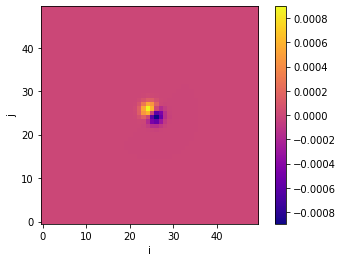

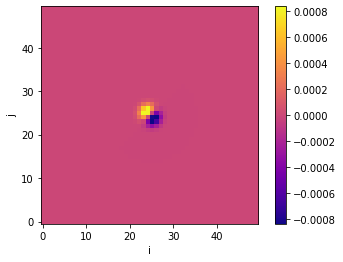

In [78]:
f_test = np.array([x[0]**2, x[0]**2, x[0]**2])
f_curl_th = np.array([np.zeros(f_test[0].shape), -2*x[0], 2*x[0]])
f_curl_man = curl_f(f_test,x)[3]


plt.figure()
plt.imshow(W_curl_man[2][:,:,20], cmap='plasma', origin='lower')
plt.colorbar()
plt.xlabel('i')
plt.ylabel('j')
plt.show()

plt.figure()
plt.imshow(W_curl_th[2][:,:,20], cmap='plasma', origin='lower')
plt.colorbar()
plt.xlabel('i')
plt.ylabel('j')
plt.show()



In [59]:
W_curl_fft_x = manual_dot(curl_recov[0], W_fft)
W_curl_fft_y = manual_dot(curl_recov[1], W_fft)
W_curl_fft_z = manual_dot(curl_recov[2], W_fft)
W_curl_fft_recovx = In_transform(W_curl_fft_x, norm_x)
W_curl_fft_recovy = In_transform(W_curl_fft_y, norm_y)
W_curl_fft_recovz = In_transform(W_curl_fft_z, norm_z)

W_curl_fthx = manual_dot(curl_fs[0], W_fft)
W_curl_fthy = manual_dot(curl_fs[1], W_fft)
W_curl_fthz = manual_dot(curl_fs[2], W_fft)
W_curl_Ifth_x = In_transform(W_curl_fthx, norm_x)
W_curl_Ifth_y = In_transform(W_curl_fthy, norm_y)
W_curl_Ifth_z = In_transform(W_curl_fthz, norm_z)

W_curl_fthx_l = manual_dot(curl_l[0], W_fft)/(k_xy*k**2)
W_curl_fthy_l = manual_dot(curl_l[1], W_fft)/(k_xy*k**2)
W_curl_fthz_l = manual_dot(curl_l[2], W_fft)/(k_xy*k**2)
W_curl_recov_xl = In_transform(W_curl_fthx_l, norm_x)
W_curl_recov_yl = In_transform(W_curl_fthy_l, norm_y)
W_curl_recov_zl = In_transform(W_curl_fthz_l, norm_z)

W_curl_fthx_r = manual_dot(curl_r[0], W_fft)/(k_xy*k**2)
W_curl_fthy_r = manual_dot(curl_r[1], W_fft)/(k_xy*k**2)
W_curl_fthz_r = manual_dot(curl_r[2], W_fft)/(k_xy*k**2)
W_curl_recov_xr = In_transform(W_curl_fthx_r, norm_x)
W_curl_recov_yr = In_transform(W_curl_fthy_r, norm_y)
W_curl_recov_zr = In_transform(W_curl_fthz_r, norm_z)

W_curl_recov_x = 0.5*(W_curl_recov_xr + W_curl_recov_xl)
W_curl_recov_y = 0.5*(W_curl_recov_yr + W_curl_recov_yl)
W_curl_recov_z = 0.5*(W_curl_recov_zr + W_curl_recov_zl)


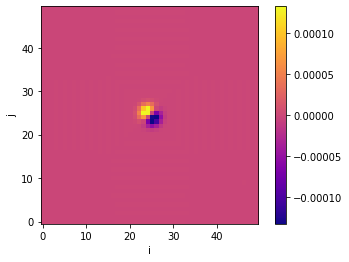

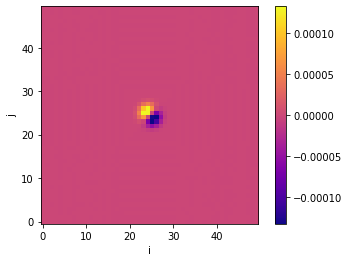

In [81]:
plt.figure()
plt.imshow(W_curl_Ifth_z.real[:,:,20],cmap='plasma',origin='lower')
plt.colorbar()
plt.xlabel('i')
plt.ylabel('j')
plt.show()

plt.figure()
plt.imshow(W_curl_recov_z.real[:,:,20],cmap='plasma',origin='lower')
plt.colorbar()
plt.xlabel('i')
plt.ylabel('j')
plt.show()
